# Lab 6: MNIST with CNN Model
The purpose of this assignment is to build, train and evaluate a Convolutional Neural Network(CNN) for handwritten digit recognition using the MNIST dataset. You will also preprocess data, visualize results, and upload the work to GitHub

# Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import MulticlassAccuracy
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import memory_profiler

In [21]:
#Check if the GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(f"Using device: {device}")

Using device: cpu


# Introduce the MNIST Dataset:

### 1. Introduction to the MNIST Dataset


The MNIST (Modified National Institute of Standards and Technology) dataset is a widely used collection of handwritten digits (0-9) which serves as a standard benchmark for testing and training image classification algorithms in machine learning.

#### Dataset Details
* Size of the dataset: MNIST contains 70000 grayscale images of handwritten digits.
   - 60000 images for training
   - 10000 images for testing
* Number of classes: 10 (digits 0 to 9)
* Image dimensions: Each image is 28x28 pixels, which represented in grayscale(values from 0 to 255)
* Format: Each image is a single channel image, it has only one color channel
  
This dataset is widely used for benchmarking machine learning models, especially Convolutional Neural Networks(CNNs)
#### Why is MNIST crucial?
* It is a simple however it is very powerful dataset for testing image classification models
* It often used for benchmarking Convolutional Neural Networks(CNNs)
* Helps in understanding image preprocessing techniques, such as normalization and transformation

In [66]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_dataset = torchvision.datasets.MNIST(root="./data", train= True, download = True, transform= transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train= False, download = True,transform= transform)

memory_used_before = memory_profiler.memory_usage()[0]

train_loader = DataLoader(train_dataset, batch_size =64, shuffle = True)
val_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

memory_used_after = memory_profiler.memory_usage()[0]

print(f"Memory consumed: {memory_used_after - memory_used_before: .2f} MB")

Memory consumed:  0.01 MB


### Preprocess the Data

#### Why the preprocessing steps were necessary?

To improve the performance of our CNN, we apply preprocessing techniques to the MNIST dataset:
- Normalization: We scale pixel values from [0,255] to [0,1] or [-1,1] to help the model train faster and improve convergence.
- ToTensor Conversion: Converts the PIL image into a PyTorch tensor, which is needed for model training.
- Other Possible Transforms: While not required, there are additional transformations which are random rotation or data augmentation could enhance generalization.

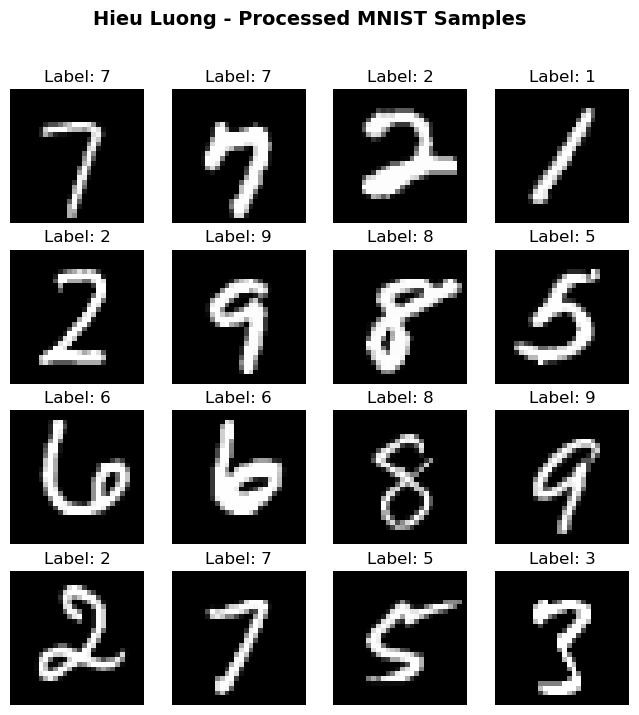

In [58]:
#Function to visualize a batch of processed images
def processed_image (dataloader, name = " Hieu Luong "):
    images, labels = next(iter(dataloader))
    images = images[:16]
    labels = labels[:16]

    fig,axes = plt.subplots(4,4, figsize=(8,8))
    fig.suptitle(f"{name} - Processed MNIST Samples", fontsize=14, fontweight="bold")
    for i,ax in enumerate(axes.flat):
        img= images[i].squeeze().numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    

    plt.show()
   

processed_image(train_loader, name="Hieu Luong")

# Build a CNN Model

### Design the Model Structure

In [67]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            #First Convolutional Layer
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(32 * 28 * 28, 10)
        )
    def forward(self,x):
        out= self.main(x)
        return out

In [68]:
model=CNN()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           4,640
              ReLU-4           [-1, 32, 28, 28]               0
           Flatten-5                [-1, 25088]               0
            Linear-6                   [-1, 10]         250,890
Total params: 255,690
Trainable params: 255,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.77
Params size (MB): 0.98
Estimated Total Size (MB): 1.74
----------------------------------------------------------------


## Use the MaxPool2d


In [69]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            #First Convolutional Layer
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(32 * 7 * 7, 128)
        )
    def forward(self,x):
        out= self.main(x)
        return out

In [70]:
model = CNN()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                  [-1, 128]         200,832
Total params: 205,632
Trainable params: 205,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.78
Estimated Total Size (MB): 1.12
----------------------------------------------------------------



### Build trainer

Implement a simple training wrapper for PyTorch network that handles the forward pass, backpropagation, and parameter updates for multiple epochs

Training Process:
- Iterate over the specified number of epochs
  
Batch Loop:

- Iterate over batches of X and y from dataloader
- Clear the gradients using optimizer.zero_grad()
- Perform a forward pass:
- Use the model to compute predictions (y_hat)
- Flatten the output to match the expected shape if necessary.
- Calculate the loss using criterion(y_hat, y)
- Perform backpropagation with loss to compute gradients
- Update model parameters using optimizer.step()
- Accumulate the loss for the batch into a running total.
  
Logging:
- At the end of each epoch, compute and print the average loss over all batches if verbose is True.

In [71]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss() # loss function - Multi class classification
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)  #Optimization algorithm - ADAM

In [74]:
def trainer(model, criterion, optimizer, train_loader, val_loader, epochs=50, device="cpu", verbose=True):
    model.to(device)
    accuracy_metric = MulticlassAccuracy(num_classes=10).to(device)  # Accuracy metric
    accuracy_list = []  # List to store the accuracy
    train_loss = []  # List to store the training loss history
    val_loss_history = []  # List to store the validation loss history
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        losses = 0  # Track total loss for training
        accuracy_metric.reset()  # Reset accuracy metric at the start of each epoch
        
        # Training loop
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()  # Reset gradients
            y_pred = model(X)  # Forward pass
            loss = criterion(y_pred, y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            losses += loss.item()  # Track total loss
            
            # Get the predicted class and compute accuracy
            predicted = torch.argmax(y_pred, dim=1)  # Get predicted class (shape: [batch_size])
            accuracy_metric.update(predicted, y)  # Update accuracy metric
        
        # Compute average training loss and accuracy
        avg_loss = losses / len(train_loader)  # Average training loss
        avg_accuracy = accuracy_metric.compute().item()  # Average accuracy
        
        # Append values to history
        train_loss.append(avg_loss)
        accuracy_list.append(avg_accuracy)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_losses = 0  # Track total validation loss
        with torch.no_grad():  # No gradient tracking during validation
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_val_pred = model(X_val)
                val_losses += criterion(y_val_pred, y_val).item()

        # Compute average validation loss
        avg_val_loss = val_losses / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # Print the training and validation loss/accuracy
        if verbose:
            print(f"Epoch {epoch+1}: Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {avg_accuracy:.4f}")
    
    return train_loss, val_loss_history, accuracy_list


In [82]:
# Train the model
loss_history,val_loss_history, accuracy_list = trainer(model, criterion, optimizer, train_loader, val_loader, epochs=50, device=device, verbose=True)


Epoch 1: Train Loss: 0.0027, Val Loss: 0.0921, Accuracy: 0.9992
Epoch 2: Train Loss: 0.0011, Val Loss: 0.0738, Accuracy: 0.9997
Epoch 3: Train Loss: 0.0001, Val Loss: 0.0763, Accuracy: 1.0000
Epoch 4: Train Loss: 0.0000, Val Loss: 0.0727, Accuracy: 1.0000
Epoch 5: Train Loss: 0.0000, Val Loss: 0.0727, Accuracy: 1.0000
Epoch 6: Train Loss: 0.0000, Val Loss: 0.0729, Accuracy: 1.0000
Epoch 7: Train Loss: 0.0000, Val Loss: 0.0737, Accuracy: 1.0000
Epoch 8: Train Loss: 0.0000, Val Loss: 0.0749, Accuracy: 1.0000
Epoch 9: Train Loss: 0.0000, Val Loss: 0.0757, Accuracy: 1.0000
Epoch 10: Train Loss: 0.0000, Val Loss: 0.0762, Accuracy: 1.0000
Epoch 11: Train Loss: 0.0000, Val Loss: 0.0784, Accuracy: 1.0000
Epoch 12: Train Loss: 0.0000, Val Loss: 0.0786, Accuracy: 1.0000
Epoch 13: Train Loss: 0.0075, Val Loss: 0.0878, Accuracy: 0.9979
Epoch 14: Train Loss: 0.0018, Val Loss: 0.0812, Accuracy: 0.9994
Epoch 15: Train Loss: 0.0013, Val Loss: 0.0863, Accuracy: 0.9996
Epoch 16: Train Loss: 0.0018, Val 

In [83]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

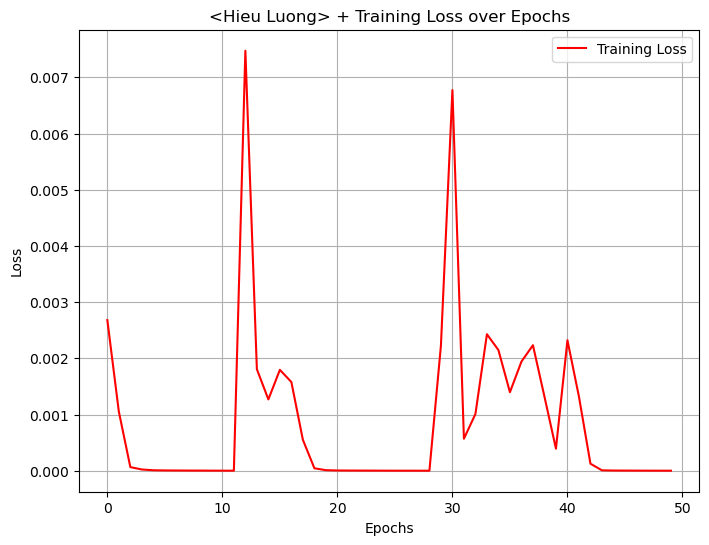

In [86]:
def plot_training_loss(train_loss):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(train_loss)), train_loss, label="Training Loss", color = "red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("<Hieu Luong> + Training Loss over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

plot_training_loss(loss_history)

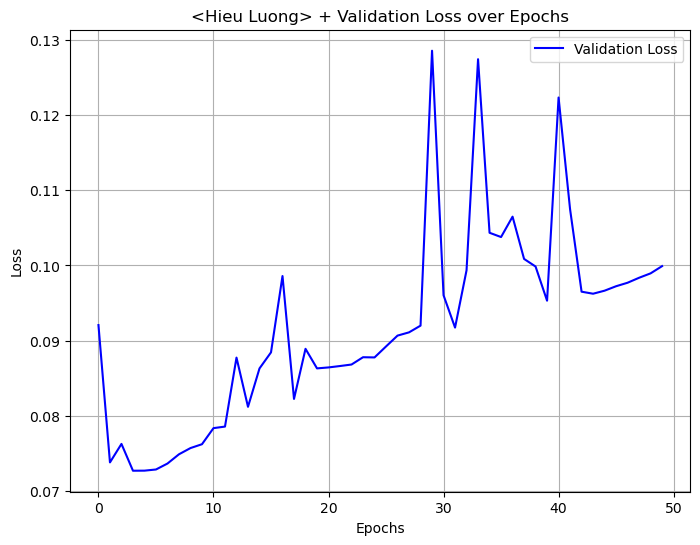

In [87]:
def plot_valid_loss(val_loss_history):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(val_loss_history)), val_loss_history, label="Validation Loss", color = "blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("<Hieu Luong> + Validation Loss over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
plot_valid_loss(val_loss_history)

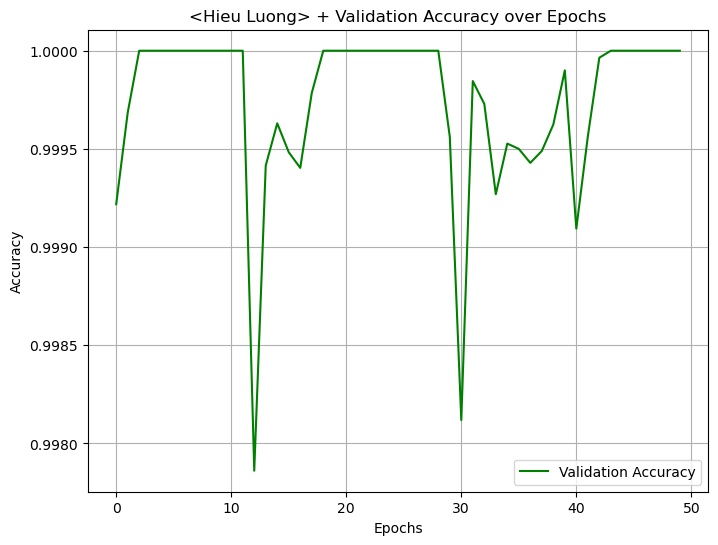

In [95]:
def plot_accuracy(accuracy_list):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(accuracy_list)), accuracy_list, label="Validation Accuracy", color = "green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("<Hieu Luong> + Validation Accuracy over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
plot_accuracy(accuracy_list)

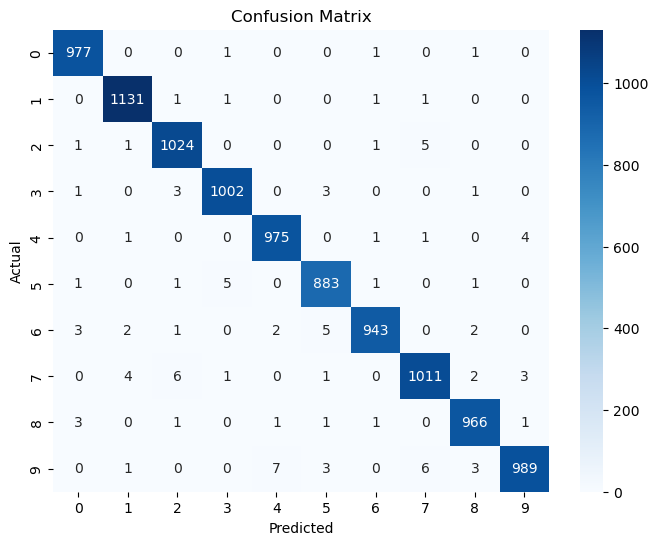

In [101]:
def plot_matrix(model,dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X,y in DataLoader(dataset, batch_size = 64):
            X,y = X.to(device), y.to(device)
            predictions = torch.argmax(model(X), dim =1 )
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("<Hieu Luong> + Confusion Matrix")
    plt.show()
plot_matrix(model, test_dataset, device)